Epistasis Analysis: Filtering the WDS-Model Meta-data for Known Epistatic Mutants

In [51]:
from deepBreaks.preprocessing import read_data
import pandas as pd
import re

def has_all_single_counterparts(row, single_mutations_df, wiggle_room = 1):
    """Checks if all individual mutations in a multi-mutant have single mutant entries and whether those mutants demonstrate epistasis."""
    wt_accession = row["WT_Acc"].split('.')[0]
    abs_diff = int(row["Reg_Diff"])
    epi_check = 0
    
    acc = row['WT_Acc']
    acc = acc.split('.')[0]
    wt_accession = re.compile(f"^{acc}")
            
    if ',' in row["Mutations"]:
        mutations = row["Mutations"].split(',') 
    elif '/' in row["Mutations"]:
        mutations = row["Mutations"].split('/') 
    else:
        mutations = row["Mutations"].split('_') 
        
 
    for mutation in mutations:
        has_countr_prt = False
        for indx in single_mutations_df.index:
            if ((wt_accession.match(single_mutations_df["WT_Acc"][indx])) and (single_mutations_df["Mutations"][indx].strip() == mutation.strip())):
                has_countr_prt = True
                epi_check += int(single_mutations_df["Reg_Diff"][indx])
                
                break
            else:
                pass
        if has_countr_prt == False:
            return False

    #Checking to see if the mutation is just additive or epistatic.
    if abs(abs_diff - epi_check) <= wiggle_room:
        is_epistatic_mut = False
    else:
        is_epistatic_mut = True
    return True, is_epistatic_mut, epi_check

MutCompFile = f"wt_mut_comp.csv"
#meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
comp_file = read_data(MutCompFile, seq_type = None, is_main=False)

In [52]:
# Extract single mutations 
single_mutations_df = comp_file[comp_file["mutant_type"] == "Single Mutation"].copy()
multi_mutations_df = comp_file[comp_file["mutant_type"] == "Multiple Mutations"].copy()


In [53]:
single_mutations_df.head()

,Mut_Acc,WT_Acc,Mutations,Mut_Lmax,WT_Lmax,Reg_Diff,Abs_Diff,Edge_Colors,mutant_type,Phylum
S131,AB043817.1_S292A,AB043817.1,S292A,498.0,486.0,-12.0,12.0,#762a83,Single Mutation,Chordata
S69,AB084929_S292A,AB084929.1,S292A,498.0,487.0,-11.0,11.0,#762a83,Single Mutation,Chordata
S71,AB084938_A292S,AB084938.1,A292S,491.0,505.0,14.0,14.0,#762a83,Single Mutation,Chordata
S70,AB084945_S292A,AB084945.1,S292A,500.0,488.0,-12.0,12.0,#762a83,Single Mutation,Chordata
S187,AB087805.2_I49C,AB087805.2,I49C,463.0,467.0,4.0,4.0,#c9c9c9,Single Mutation,Chordata


In [54]:
multi_mutations_df.head()

,Mut_Acc,WT_Acc,Mutations,Mut_Lmax,WT_Lmax,Reg_Diff,Abs_Diff,Edge_Colors,mutant_type,Phylum
S195,AB087805.2_L46F_I49C_S94T_V111A_M112I,AB087805.2,"L46F, I49C, S94T, V111A, M112I",472.0,467.0,-5.0,5.0,#c9c9c9,Multiple Mutations,Chordata
S194,AB087805.2_S94T_V111A_M112I,AB087805.2,"S94T, V111A, M112I",471.0,467.0,-4.0,4.0,#c9c9c9,Multiple Mutations,Chordata
S193,AB087805.2_V111A_M112I,AB087805.2,"V111A, M112I",470.0,467.0,-3.0,3.0,#c9c9c9,Multiple Mutations,Chordata
S413,AB208675.1_S117A_F177Y,AB208675.1,"S117A,F177Y",425.0,450.0,25.0,25.0,#762a83,Multiple Mutations,Streptophyta
S171,AB223053.1_Q122E_S292A,AB223053.1,"Q122E, S292A",469.0,452.0,-17.0,17.0,#762a83,Multiple Mutations,Chordata


In [55]:
has_singles_list = []
is_epistatic_list = []
additive_effects = []

for row in multi_mutations_df.index:
    try:
        has_singles,is_epistatic,addEfct= has_all_single_counterparts(multi_mutations_df.loc[row], single_mutations_df)
        has_singles_list.append(has_singles)
        is_epistatic_list.append(is_epistatic)
        additive_effects.append(addEfct)
    except:    
        has_singles_list.append((has_all_single_counterparts(multi_mutations_df.loc[row], single_mutations_df)))
multi_mutations_df["has_all_singles"] = has_singles_list

In [57]:
# Filter to keep only the desired multi-mutants
filtered_multi_mutations_df = multi_mutations_df[multi_mutations_df["has_all_singles"]].copy()
filtered_multi_mutations_df = filtered_multi_mutations_df.drop(columns="has_all_singles")
filtered_multi_mutations_df["is_epistatic_mut"] = is_epistatic_list
filtered_multi_mutations_df["additive_exp_shift"] = additive_effects
filtered_multi_mutations_df.head()

,Mut_Acc,WT_Acc,Mutations,Mut_Lmax,WT_Lmax,Reg_Diff,Abs_Diff,Edge_Colors,mutant_type,Phylum,is_epistatic_mut,additive_exp_shift
S195,AB087805.2_L46F_I49C_S94T_V111A_M112I,AB087805.2,"L46F, I49C, S94T, V111A, M112I",472.0,467.0,-5.0,5.0,#c9c9c9,Multiple Mutations,Chordata,True,7
S194,AB087805.2_S94T_V111A_M112I,AB087805.2,"S94T, V111A, M112I",471.0,467.0,-4.0,4.0,#c9c9c9,Multiple Mutations,Chordata,True,0
S193,AB087805.2_V111A_M112I,AB087805.2,"V111A, M112I",470.0,467.0,-3.0,3.0,#c9c9c9,Multiple Mutations,Chordata,True,0
S413,AB208675.1_S117A_F177Y,AB208675.1,"S117A,F177Y",425.0,450.0,25.0,25.0,#762a83,Multiple Mutations,Streptophyta,True,17
S823,AF133907_I46F_V49I_G164A,AF133907,"I46F,V49I,G164A",438.0,437.0,-1.0,1.0,#c9c9c9,Multiple Mutations,Chordata,True,-5


In [59]:
epistatic_muts_df = filtered_multi_mutations_df[filtered_multi_mutations_df["is_epistatic_mut"]].copy()
epistatic_muts_df = epistatic_muts_df.drop(columns="is_epistatic_mut")
epistatic_muts_df.head()

,Mut_Acc,WT_Acc,Mutations,Mut_Lmax,WT_Lmax,Reg_Diff,Abs_Diff,Edge_Colors,mutant_type,Phylum,additive_exp_shift
S195,AB087805.2_L46F_I49C_S94T_V111A_M112I,AB087805.2,"L46F, I49C, S94T, V111A, M112I",472.0,467.0,-5.0,5.0,#c9c9c9,Multiple Mutations,Chordata,7
S194,AB087805.2_S94T_V111A_M112I,AB087805.2,"S94T, V111A, M112I",471.0,467.0,-4.0,4.0,#c9c9c9,Multiple Mutations,Chordata,0
S193,AB087805.2_V111A_M112I,AB087805.2,"V111A, M112I",470.0,467.0,-3.0,3.0,#c9c9c9,Multiple Mutations,Chordata,0
S413,AB208675.1_S117A_F177Y,AB208675.1,"S117A,F177Y",425.0,450.0,25.0,25.0,#762a83,Multiple Mutations,Streptophyta,17
S823,AF133907_I46F_V49I_G164A,AF133907,"I46F,V49I,G164A",438.0,437.0,-1.0,1.0,#c9c9c9,Multiple Mutations,Chordata,-5


In [ ]:
epistatic_muts_df.to_csv(path_or_buf= f'epistatic_muts.csv',index_label=True,mode="w")

Epistasis Analysis: Checking the Performance of Different Models on Predicting Epistasis

In [1]:
from deepBreaks.preprocessing import read_data
import pandas as pd

EpitestFileName = f"epistasis_full_test_results_lgbm.csv"
WdstestFileName = f"wds_itr_test_results.csv"
WTtestFileName = f"wt_all_muts_pred_results.csv"

epi_test = read_data(EpitestFileName, seq_type = None, is_main=False)
wds_test = read_data(WdstestFileName, seq_type = None, is_main=False)
wt_test = read_data(WTtestFileName, seq_type = None, is_main=False)

In [2]:
epi_acc_list = epi_test.Accession.to_list()

epi_test = epi_test.set_index(epi_test['Accession'])
epi_test = epi_test.drop(columns='Accession')

wds_test = wds_test.set_index(wds_test['Accession'])
wds_test = wds_test.drop(columns='Accession')
wds_test = wds_test.loc[epi_acc_list]

wt_test = wt_test.set_index(wt_test['Accession'])
wt_test = wt_test.drop(columns='Accession')
wt_test = wt_test.loc[epi_acc_list]

In [3]:
epi_test['Sqr_Err'] = epi_test['Difference']**2
wds_test['Sqr_Err'] = wds_test['Difference']**2
wt_test['Sqr_Err'] = wt_test['Difference']**2

epi_test = epi_test.sort_values('Accession')
wds_test = wds_test.sort_values('Accession')
wt_test = wt_test.sort_values('Accession')

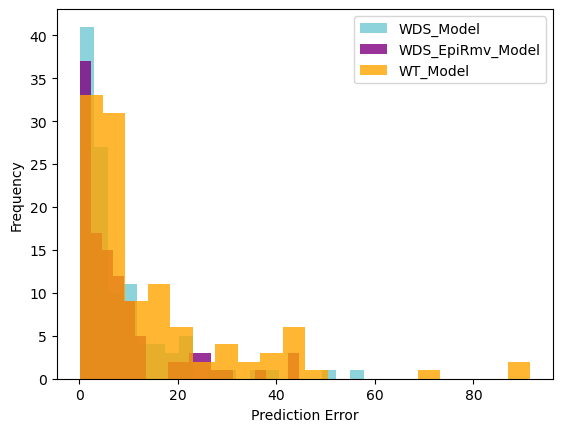

In [36]:

import matplotlib.pyplot as plt
import scipy.stats as st
# ... (your existing code to calculate errors_model1 and errors_model2)

# Histogram
plt.hist(abs(wds_test['Difference']), bins=20, alpha=0.6, label='WDS_Model', color='#41b6c4')
plt.hist(abs(epi_test['Difference']), bins=20, alpha=0.8, label='WDS_EpiRmv_Model', color='purple')
plt.hist(abs(wt_test['Difference']), bins=20, alpha=0.8, label='WT_Model', color='orange')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.legend()
#plt.title('Histogram of Prediction Errors')
plt.show()

In [6]:
import scipy.stats as st
import statistics

# Perform Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. WT]
print("Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. WT]")

statistic, p_value = st.wilcoxon(wds_test['Sqr_Err'], wt_test['Sqr_Err'], alternative='less')
print("Wilcoxon Test: Statistic =", statistic, "p-value =", p_value, "\n")

print(f"Median of WDS-Model Square-Error = {statistics.median(wds_test['Sqr_Err']):.1f}nm\nMean of WDS-Model Square-Error (MSE) = {statistics.mean(wds_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wds_test['Sqr_Err'])):.1f}nm\n")
print(f"Median of WT-Model Square-Error = {statistics.median(wt_test['Sqr_Err']):.1f}nm\nMean of WT-Model Square-Error (MSE) = {statistics.mean(wt_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wt_test['Sqr_Err'])):.1f}nm")

Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. WT]
Wilcoxon Test: Statistic = 1371.0 p-value = 1.604624812709871e-07 

Median of WDS-Model Square-Error = 22.1nm
Mean of WDS-Model Square-Error (MSE) = 157.3 // Root Mean Square Error (RMSE) = 12.5nm

Median of WT-Model Square-Error = 65.3nm
Mean of WT-Model Square-Error (MSE) = 495.2 // Root Mean Square Error (RMSE) = 22.3nm


In [7]:
import scipy.stats as st
import statistics

# Perform Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. EpiRmv-WDS]
print("Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. EpiRmv-WDS]")

statistic, p_value = st.wilcoxon(epi_test['Sqr_Err'], wds_test['Sqr_Err'], alternative='two-sided')
print("Wilcoxon Test: Statistic =", statistic, "p-value =", p_value, "\n")

print(f"Median of WDS-Model Square-Error = {statistics.median(wds_test['Sqr_Err']):.1f}nm\nMean of WDS-Model Square-Error (MSE) = {statistics.mean(wds_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wds_test['Sqr_Err'])):.1f}nm\n")
print(f"Median of EpiRmv-WDS-Model Square-Error = {statistics.median(epi_test['Sqr_Err']):.1f}nm\nMean of EpiRmv-Model Square-Error (MSE) = {statistics.mean(epi_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(epi_test['Sqr_Err'])):.1f}nm")

Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. EpiRmv-WDS]
Wilcoxon Test: Statistic = 2894.0 p-value = 0.5289262076569157 

Median of WDS-Model Square-Error = 22.1nm
Mean of WDS-Model Square-Error (MSE) = 157.3 // Root Mean Square Error (RMSE) = 12.5nm

Median of EpiRmv-WDS-Model Square-Error = 25.3nm
Mean of EpiRmv-Model Square-Error (MSE) = 153.0 // Root Mean Square Error (RMSE) = 12.4nm


In [9]:
import scipy.stats as st
import statistics

# Perform Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WT vs. EpiRmv-WDS]
print("Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WT vs. EpiRmv-WDS]")

statistic, p_value = st.wilcoxon(epi_test['Sqr_Err'], wt_test['Sqr_Err'], alternative='less')
print("Wilcoxon Test: Statistic =", statistic, "p-value =", p_value, "\n")

print(f"Median of WT-Model Square-Error = {statistics.median(wt_test['Sqr_Err']):.1f}nm\nMean of WT-Model Square-Error (MSE) = {statistics.mean(wt_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wt_test['Sqr_Err'])):.1f}nm\n")
print(f"Median of EpiRmv-WDS-Model Square-Error = {statistics.median(epi_test['Sqr_Err']):.1f}nm\nMean of EpiRmv-Model Square-Error (MSE) = {statistics.mean(epi_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(epi_test['Sqr_Err'])):.1f}nm")

Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WT vs. EpiRmv-WDS]
Wilcoxon Test: Statistic = 1507.0 p-value = 1.2350725053243509e-06 

Median of WT-Model Square-Error = 65.3nm
Mean of WT-Model Square-Error (MSE) = 495.2 // Root Mean Square Error (RMSE) = 22.3nm

Median of EpiRmv-WDS-Model Square-Error = 25.3nm
Mean of EpiRmv-Model Square-Error (MSE) = 153.0 // Root Mean Square Error (RMSE) = 12.4nm


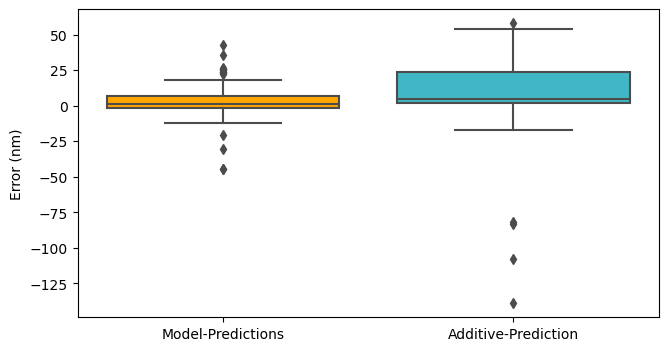

<Figure size 640x480 with 0 Axes>

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but it enhances the aesthetics of plots
import pandas as pd

plt.figure(figsize = [7.50, 4.00])
#palette = sns.color_palette("Set2")
palette = ['orange','#41b6c4', ]

sns.boxplot(data=[epi_test['Difference'],epi_test['Adtv_Err']], dodge=False, palette=palette, saturation=1)
# Customize axis labels
plt.xticks([0, 1], ["Model-Predictions", "Additive-Prediction"])
#plt.xlabel('Predictor')
plt.ylabel('Error (nm)')

#save file
fileout = 'epi_iter_test_err2_bxplts.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'epi_iter_test_err2_bxplts.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

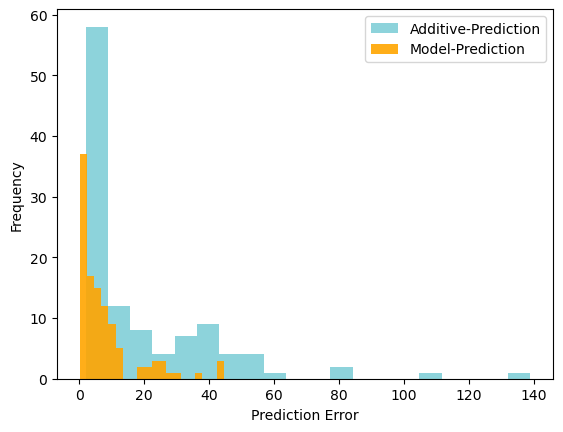

In [50]:
import matplotlib.pyplot as plt
import scipy.stats as st
# ... (your existing code to calculate errors_model1 and errors_model2)

# Histogram
plt.hist(abs(epi_test['Adtv_Err']), bins=20, alpha=0.6, label='Additive-Prediction', color='#41b6c4')
plt.hist(abs(epi_test['Difference']), bins=20, alpha=0.9, label='Model-Prediction', color='orange')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.legend()
#plt.title('Histogram of Prediction Errors')
plt.show()

In [44]:
import scipy.stats as st
import statistics

# Perform Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. Exp-Additive]
print("Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. Exp-Additive]")

statistic, p_value = st.wilcoxon(wds_test['Sqr_Err'], epi_test['Adtv_Err']**2, alternative='less')
print("Wilcoxon Test: Statistic =", statistic, "p-value =", p_value, "\n")

print(f"Median of WDS-Model Square-Error = {statistics.median(wds_test['Sqr_Err']):.1f}nm\nMean of WDS-Model Square-Error (MSE) = {statistics.mean(wds_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wds_test['Sqr_Err'])):.1f}nm\n")
print(f"Median of Exp-Additive Square-Error = {statistics.median(epi_test['Adtv_Err']**2):.1f}nm\nMean of Exp-Additive Square-Error (MSE) = {statistics.mean(epi_test['Adtv_Err']**2):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(epi_test['Adtv_Err']**2)):.1f}nm")

Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. Exp-Additive]
Wilcoxon Test: Statistic = 1308.0 p-value = 5.915491593559079e-08 

Median of WDS-Model Square-Error = 22.1nm
Mean of WDS-Model Square-Error (MSE) = 157.3 // Root Mean Square Error (RMSE) = 12.5nm

Median of Exp-Additive Square-Error = 64.0nm
Mean of Exp-Additive Square-Error (MSE) = 885.9 // Root Mean Square Error (RMSE) = 29.8nm


In [47]:
import scipy.stats as st
import statistics

# Perform Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. Exp-Additive]
print("Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. Exp-Additive]")

statistic, p_value = st.wilcoxon(wt_test['Sqr_Err'], epi_test['Adtv_Err']**2, alternative='less')
print("Wilcoxon Test: Statistic =", statistic, "p-value =", p_value, "\n")

print(f"Median of WT-Model Square-Error = {statistics.median(wt_test['Sqr_Err']):.1f}nm\nMean of WT-Model Square-Error (MSE) = {statistics.mean(wt_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wt_test['Sqr_Err'])):.1f}nm")
print(f"Median of Exp-Additive Square-Error = {statistics.median(epi_test['Adtv_Err']**2):.1f}nm\nMean of Exp-Additive Square-Error (MSE) = {statistics.mean(epi_test['Adtv_Err']**2):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(epi_test['Adtv_Err']**2)):.1f}nm")

Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. Exp-Additive]
Wilcoxon Test: Statistic = 2643.0 p-value = 0.08563149873275355 

Median of WT-Model Square-Error = 65.3nm
Mean of WT-Model Square-Error (MSE) = 495.2 // Root Mean Square Error (RMSE) = 22.3nm
Median of Exp-Additive Square-Error = 64.0nm
Mean of Exp-Additive Square-Error (MSE) = 885.9 // Root Mean Square Error (RMSE) = 29.8nm
